# Classificação de imagens com TenserFlow Keras

In [ ]:
url = "/content/drive/MyDrive/Google AI Studio/uvas/uvas"

In [ ]:
import pathlib

In [ ]:
data_dir = pathlib.Path(url)

In [ ]:
len(list(data_dir.glob('*/*.JPG')))

1600

In [ ]:
subfolders = [f.name for f in data_dir.iterdir() if f.is_dir()]
subfolders

['BlackMeasles', 'BlackRot', 'HealthyGrapes', 'LeafBlight']

In [ ]:
import PIL

In [ ]:
leafblight = list(data_dir.glob('LeafBlight/*'))

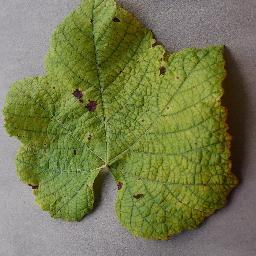

In [ ]:
PIL.Image.open(str(leafblight[0]))

In [ ]:
import numpy as np

In [ ]:
for subfolder in subfolders:
    path = data_dir/subfolder
    images = list(path.glob('*.JPG'))
    print(f'Classe {subfolder} tem {len(images)} imagens')


    # Esse código vai mostrar as dimensões em pixels das imagens (altura, largura, n de canais)
    if images:
      img = PIL.Image.open(str(images[0]))
      img_array = np.array(img)
      print(f'Dimensão da primeira imagem em {subfolder}: {img_array.shape}')

Classe BlackMeasles tem 400 imagens
Dimensão da primeira imagem em BlackMeasles: (256, 256, 3)
Classe BlackRot tem 400 imagens
Dimensão da primeira imagem em BlackRot: (256, 256, 3)
Classe HealthyGrapes tem 400 imagens
Dimensão da primeira imagem em HealthyGrapes: (256, 256, 3)
Classe LeafBlight tem 400 imagens
Dimensão da primeira imagem em LeafBlight: (256, 256, 3)


In [ ]:
import tensorflow as tf

In [ ]:
batch_size = 64
altura = 256
largura = 256

In [ ]:
treino = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=568,
    image_size=(altura,largura),
    batch_size=batch_size
)

Found 1600 files belonging to 4 classes.
Using 1280 files for training.


In [ ]:
validacao = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=568,
    image_size=(altura,largura),
    batch_size=batch_size
)

Found 1600 files belonging to 4 classes.
Using 320 files for validation.


In [ ]:
treino.class_names

['BlackMeasles', 'BlackRot', 'HealthyGrapes', 'LeafBlight']

Antes de mais nada, precisaremos definir um random seed, porque a nossa rede neural terá pesos, e esses pesos são inicializados de forma aleatória.

In [ ]:
tf.random.set_seed(424242)

# Criando o modelo de rede neural

O modelo será igual a tf.keras.models.Sequential(). Dentro desse Sequential(), será passado uma série de camadas da nossa rede neural, ou seja, a sequência de processamento que será feita do dado até a saída, até a nossa classificação.

Então, será passada a imagem e gerar um resultado de classificação, indicando se a imagem corresponde a uma das quatro classes do nosso dataset.

Passagem da imagem: Primeiro, é necessário definir o tamanho da nossa entrada, no comando tf.keras.layers.Input(), passando o shape por parâmetro, definindo o tamanho como 256,256,3, com as dimensões e os canais das imagens. Então: tf.keras.layers.Input(shape=(256, 256, 3)).

Os valores dos pixels das imagens variam de 0 até 255. Porém, para o bom funcionamento da rede neural, o ideal é que esses valores variem de 0 até 1. Por isso, é necessário reescalar os valores, fazendo uma divisão de todos os valores dos pixels por 255: tf.keras.layers.Rescaling(1./255).

Na próxima camada (camada Dense), precisamos passar uma sequência de números. Então, é necessário redimensionar a imagem para uma sequência de números, usando o tf.keras.layers.Flatten() para achatar a imagem.

Entrando na rede neural: Será construida uma camada densa para a nossa rede neural, que seria uma camada intermediária (hidden layer), que seria uma camada de neurônios.

Para isso, adicionamos ao modelo tf.keras.layers.Dense(). Como parâmetro, serão passados 128 neurônios para essa camada, além de definir uma função de ativação para ela, com activation=tf.nn.relu.

A camaa de saída terá quatro saídas, representando cada uma das quatro classes. Para isso, será definido outra camada densa, mas agora passando como parâmetros 4 neurônios e a função de ativação activation=tf.nn.softmax. Essa é uma função de ativação comum para quando temos um problema de classificação multiclasse.

In [ ]:
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),          # informa ao modelo o formato dos dados de entrada
    tf.keras.layers.Rescaling(1./255),                   # normaliza os dados de entrada
    tf.keras.layers.Flatten(),                           # converte a matriz de pixels 2D da imagem em um vetor 1D (passo necessário para conectar as camas densas)
    tf.keras.layers.Dense(128, activation=tf.nn.relu),   # Cama fully conected recebe entrada de todos os neurônios da camada anterior (ReLU - ajuda a rede a capturar padrões complexos nos dados)
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)   # outra camada densa, mas desta vez com 4 neurônios (Softmax - transforma os valores de saída em probabilidades que somam 1)
])

# Compilando o modelo

Primiero tem que ser passado um otimizador, e após é necessário escolher uma função de custo (loss), que vai verificar como a nossa rede neural está evoluindo no decorrer do treinamento.

Uma métrica adequada para o nosso caso de classificação seria o sparse_categorical_crossentropy, que será recebida por loss.

Por fim, também é definida uma métrica que vai ajudar a verificar se a rede neural está evoluindo bem no critério de classificação (Acurácia).

In [ ]:
modelo.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics =  ['accuracy']
)

# Configurando a GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Treinando o modelo

Agora será feito o treinamento dessa rede neural por 10 épocas (quantidade de iterações que o algoritmo fará).

Também será adicionada a variável history para guardar o treinamento do nosso modelo.

Recapitulando: dentro desse .fit(), estamos passando os nossos dados de treino, a validação e as épocas. Ele fará uma simulação de classificação dos dados de treino com os pesos aleatórios e verificará a porcentagem de erro (loss) determinada para esse caso.

Com base nesse valor de loss ele fará um ajuste do peso, num processo chamado retropropagação.

In [ ]:
epocas =10

history = modelo.fit(
    treino,
    validation_data=validacao,
    epochs=epocas
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 407s 20s/step - accuracy: 0.2789 - loss: 86.2160 - val_accuracy: 0.3625 - val_loss: 12.8178
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - accuracy: 0.4185 - loss: 10.2604 - val_accuracy: 0.7000 - val_loss: 2.0451
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.6344 - loss: 2.7829 - val_accuracy: 0.6969 - val_loss: 2.4645
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.6999 - loss: 2.0917 - val_accuracy: 0.7344 - val_loss: 1.5073
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.6904 - loss: 1.7152 - val_accuracy: 0.7312 - val_loss: 1.3641
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.7321 - loss: 1.1992 - val_accuracy: 0.7031 - val_loss: 1.3324
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.7811 - loss: 0.9451 - val_accuracy: 0.7500 - val_loss: 1.1425
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.7081 - loss: 1.5928 - val_accurac

Lembrando que apenas os dados de treino são usados ao longo das épocas, mas o algoritmo também oferece uma métrica em relação aos dados de validação para verificar como a rede neural está evoluindo no decorrer do treinamento.

In [ ]:
# visualizando os resultados
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 196608)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,165,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,499,406 (288.01 MB)

 Trainable params: 25,166,468 (96.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,332,938 (192.00 MB)

Número de elementos após o processo de flattening: multiplicação das dimensões 256,256,3, o que dá 196.608. Número qu corresponde à sequência de valores da imagem (ou seja, um elemento para cada pixel da imagem para cada camada do RGB).

Na camada densa. temos uma camada com 128 neurônios e pouco mais de 2 milhõesde parâmetros treináveis nessa rede neural. Esses parâmetros treináveis são os pesos, ou seja, as ligações entre os neurônios das nossas camadas. Por isso temos tantos parâmetros no nosso modelo.

# Função para visualizar resultados

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plota_resultados(history,epocas):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  intervalo_epocas = range(epocas)
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(intervalo_epocas, acc, label='Acurácia do Treino')
  plt.plot(intervalo_epocas, val_acc, label='Acurácia da Validação')
  plt.legend(loc='lower right')


  plt.subplot(1, 2, 2)
  plt.plot(intervalo_epocas, loss, label='Custo do Treino')
  plt.plot(intervalo_epocas, val_loss, label='Custo da Validação')
  plt.legend(loc='upper right')
  plt.show()

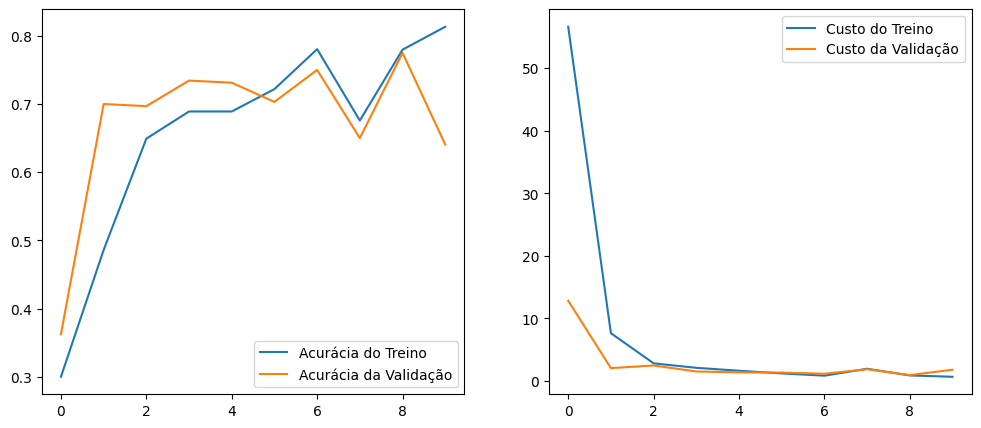

In [ ]:
#À esquerda temos os valores de acurácia e à direita temos os valores de perda, ou loss.
plota_resultados(history,epocas)

# **Estruturando uma rede convolucional**

Criando camadas na rede neural que favoreçam a classificação de imagens

## Criando uma sequência de camadas

- Camada Convolucional

No escopo da estrutura de Sequential(), vamos adicionar uma camada convolucional (Conv2D) logo após o processo de Rescaling()

A camada convolucional será responsável por passar filtros pelas imagens. Nesse caso, passamos 32 filtros e, consequentemente, geramos 32 versões da imagem. Esses filtros têm tamanho de 3 por 3 pixels, por isso passamos (3,3) entre parênteses.

Quem decide os filtros que serão passados pelas imagens é a própria rede neural durante o treinamento. Ela irá ajustar os parâmetros dos filtros, adotando os que favorecem o processo de classificação.

- Camada Pooling

Camada responsável por processo de redução de dimensionalidade, ou seja, reduzimos um pouco a quantidade de informação gerada em relação à passagem dos filtros convolucionais na imagem.

Passaremos a camada MaxPooling2D() na linha 5, logo após Conv2D().
Passamos isso como um filtro pela imagem, com o tamanho de 2 por 2 pixels. Dentro desse quadrado de 2 por 2 pixels, pegamos sempre o maior valor dos 4 valores retornados.

- Repetindo processos anteriores

Não precisamos adicionar apenas uma única camada convolucional. Nesse caso, por exemplo, será repetido o processo de passagem da camada convolucional e da camada MaxPooling2D. Podemos simplesmente copiar as duas camadas adicionadas anteriormente e colar logo abaixo no código.

In [ ]:
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

In [ ]:
# Compilando o modelo

modelo.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Treinando a rede neural

epocas = 10

history = modelo.fit(
    treino,
    validation_data=validacao,
    epochs=epocas
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 344ms/step - accuracy: 0.2610 - loss: 4.3463 - val_accuracy: 0.2562 - val_loss: 1.2673
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - accuracy: 0.3830 - loss: 1.1622 - val_accuracy: 0.7344 - val_loss: 0.5953
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.8065 - loss: 0.4902 - val_accuracy: 0.8344 - val_loss: 0.4341
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.9130 - loss: 0.2614 - val_accuracy: 0.8687 - val_loss: 0.3371
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9449 - loss: 0.1820 - val_accuracy: 0.9062 - val_loss: 0.2239
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.9821 - loss: 0.0869 - val_accuracy: 0.9125 - val_loss: 0.2281
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.9877 - loss: 0.0508 - val_accuracy: 0.9344 - val_loss: 0.1720
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.9855 - loss: 0.0468 - val_accuracy: 

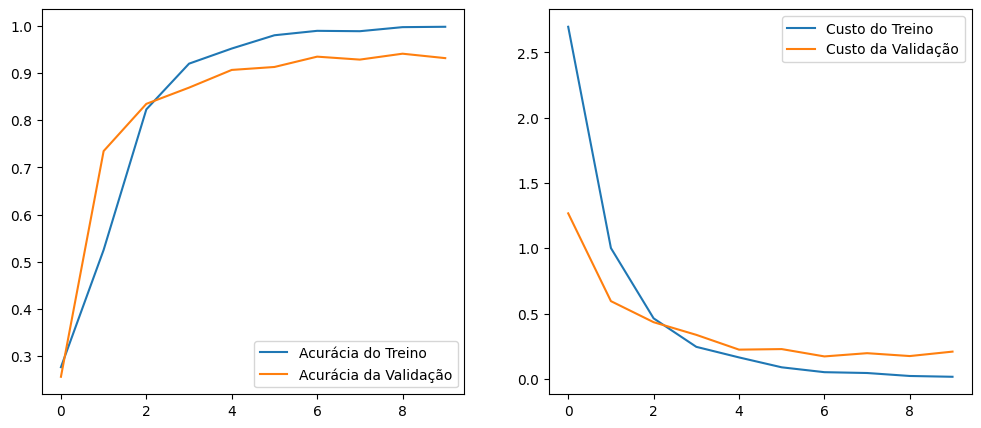

In [ ]:
plota_resultados(history, epocas)

In [ ]:
modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      15,745,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,267,438 (180.31 MB)

 Trainable params: 15,755,812 (60.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,511,626 (120.21 MB)

Alcançamos valores tão altos de acurácia que a rede não está performando tão bem nos dados de validação, ou seja, talvez ela esteja memorizando os dados de treino sem conseguir generalizar e pegar os dados que ela não visualizou durante o treinamento (Overfit)

a técnica chamada Early Stopping permitirá lidar com esse problema interrompendo o treinamento de forma antecipada.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Função para monitorar o treinamento
    if(logs.get('accuracy') >= 0.93):   #critério de parada
      print("\n Alcançamos 93% de acurácia. Parando o treinamento!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    tf.keras.layers.Rescaling(1./255),
    # Add convolutions and max pooling
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

modelo.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epocas =10

history = modelo.fit(
    treino,
    validation_data=validacao,
    epochs=epocas,
    callbacks=[callbacks]
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 586s 29s/step - accuracy: 0.2489 - loss: 4.1641 - val_accuracy: 0.4906 - val_loss: 1.0028
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 282ms/step - accuracy: 0.5970 - loss: 0.9104 - val_accuracy: 0.7781 - val_loss: 0.5548
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.8445 - loss: 0.4214 - val_accuracy: 0.8594 - val_loss: 0.3453
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9335 - loss: 0.2020
 Alcançamos 93% de acurácia. Parando o treinamento!
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.9341 - loss: 0.2009 - val_accuracy: 0.9094 - val_loss: 0.2478


A seguir, um exemplo simples de como  modificar a rede para experimentar:

In [ ]:
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),  # Camada adicional
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),      # Mais neurônios
    tf.keras.layers.Dropout(0.5),                           # Dropout adicionado
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)      # Ajuste para classificação binária
])

modelo.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),  # Taxa de aprendizado ajustada
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Para classificação multiclasse, use:
# modelo.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# Data Augmentation

Técnica que nos permitirá aumentar a base de dados, adicionando um pouco de variabilidade aos dados.

Para fazer isso, será necessário adicionar mais camadas ao Sequential(). Começaremos definindo em uma nova célula o data_augmentation, que será igual a tf.keras.Sequential().

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal"),  # Rebatimento horizontal
    tf.keras.layers.RandomRotation(0.05),      # Adiciona uma pequena rotação as imagens
    tf.keras.layers.RandomZoom(0.05),          # Aplica zoom as imagens
  ]
)

In [ ]:
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    # Adiciona linha com data_augmentation
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    # Add convolutions and max pooling
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

modelo.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epocas = 50

history = modelo.fit(
    treino,
    validation_data=validacao,
    epochs=epocas,
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.3087 - loss: 4.3064 - val_accuracy: 0.4875 - val_loss: 0.9588
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.6511 - loss: 0.8073 - val_accuracy: 0.7594 - val_loss: 0.5822
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.7998 - loss: 0.5206 - val_accuracy: 0.7312 - val_loss: 0.8356
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.8555 - loss: 0.3556 - val_accuracy: 0.7312 - val_loss: 0.9193
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.8615 - loss: 0.3521 - val_accuracy: 0.6875 - val_loss: 1.0624
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.8812 - loss: 0.3049 - val_accuracy: 0.7437 - val_loss: 1.0050
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.9041 - loss: 0.2542 - val_accuracy: 0.7812 - val_loss: 0.9449
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.9209 - loss: 0.2087 - val_accuracy: 

In [ ]:
plota_resultados(history, epocas)

In [ ]:
# Salvar o modelo
modelo.save('modelo_apos_aumento.h5')